# Differential drive robot (i.e., "segbot") in artificial gravity

Import modules and configure the notebook.

In [18]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import sympy as sym
from scipy import linalg
from scipy import signal

# Suppress the use of scientific notation when printing small numbers
np.set_printoptions(suppress=True)

# Plotting libraries and settings
import matplotlib.pyplot as plt
from matplotlib import cm
plt.rcParams['font.serif'] = "Palatino"
plt.rcParams['font.family'] = "serif"

# This is my own script (it is an interface to the pybullet simulator)
import ae353_segbot

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the "latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_segbot)

<module 'ae353_segbot' from '/Users/patrickthornton/Desktop/ae353 - Design Projects/DP2 - segbot/ae353-DP2-segbot/ae353_segbot.py'>

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `width` and `height` (positive integers, default `640` and `480`, respectively) is the weight and height of the simulation window (if shown) in pixels;
* `bumpy` (`True` or `False`) is whether or not the station is "bumpy".

**You must evaluate this cell only *once*.** If you want to start fresh with a new simulator, you must do `Kernel -> Restart` from the notebook menu first. If you evaluate this cell more than once without a call to `Kernel -> Restart` then you may get strange behavior that is hard to debug.

In [2]:
simulator = ae353_segbot.Simulator(
    display=False,
    width=480,
    height=320,
    bumpy=True,
)

## Compute full equations of motion and construct $f$

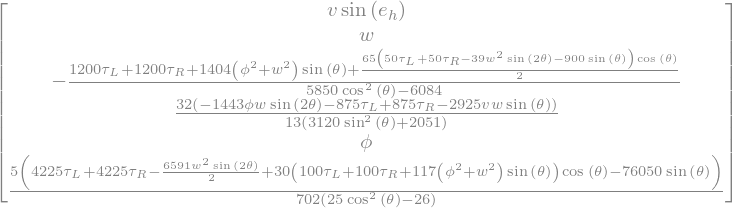

In [3]:
### Define physical constants, consistent with the URDF file:
# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Station parameters
station_velocity = -0.5 # <-- FIXME (change the velocity to change gravity)
station_radius = 20.    # <-- radius in meters of inside surface of station

# Acceleration of artifical gravity
g = station_velocity**2 * station_radius

### Convert all physical constants to rational numbers:
# Dimensions
h = sym.nsimplify(h)
a = sym.nsimplify(a)
r = sym.nsimplify(r)

# Masses
mb = sym.nsimplify(mb)
mw = sym.nsimplify(mw)
m = sym.nsimplify(m)

# MOIs
Jx = sym.nsimplify(Jx)
Jy = sym.nsimplify(Jy)
Jz = sym.nsimplify(Jz)
Jw = sym.nsimplify(Jw)
Jwt = sym.nsimplify(Jwt)

# Gravity
g = sym.nsimplify(g)

### Define variables
(e_l, e_h, v, w, theta, thetadot, phi, phidot, tau_R, tau_L) = sym.symbols('e_l, e_h, v, w, theta, thetadot, phi, phidot, tau_R, tau_L', real=True)

### Compute equations of motion, excluding lateral and heading errors (see Tuttle, 2014):
M = sym.Matrix([[m + 2 * Jw / r**2, 0, mb * h * sym.cos(theta)],
                [0, (Jx + mb * h**2) * sym.sin(theta)**2 + Jz * sym.cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
                [mb * h * sym.cos(theta), 0, Jy * mb * h**2]])
N = sym.Matrix([[mb * h * (w**2 + phi**2) * sym.sin(theta)],
                [-2 * (Jx - Jz + m * h**2) * sym.cos(theta) * sym.sin(theta) * w * phi - mb * h * sym.sin(theta) * v * w],
                [(Jx - Jz + mb * h**2) * sym.cos(theta) * sym.sin(theta) * w**2 + mb * g * h * sym.sin(theta)]])
R = sym.Matrix([[1 / r, 1 / r],
                [-a / r, a / r],
                [-1, -1]])
f = sym.simplify(M.inv() * (N + R * sym.Matrix([[tau_L], [tau_R]])))

### Compute full equations of motion (define right side of ODEs):
f = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [f]])

### Replace second-order ODE with two first-order ODEs
f = f.row_insert(4, sym.Matrix([[phi]]))

### Convert floating-point to rational numbers
f = sym.nsimplify(f, rational=True)
f

## Define a function to return a state-space model for a given choice of equilibrium point.

In [4]:
def get_model(
    e_l_e,
    e_h_e,
    v_e,
    w_e,
    theta_e,
    phi_e,
    tau_R_e,
    tau_L_e
):
    
    # Find A and B in symbolic form
    A_sym = f.jacobian([e_l, e_h, v, w, theta, phi])
    
    B_sym = f.jacobian([tau_R, tau_L])
    
    # Create lambda functions to allow numerical evaluation of A and B
    A_num = sym.lambdify([e_l, e_h, v, w, theta, phi, tau_R, tau_L], A_sym)
    
    B_num = sym.lambdify([e_l, e_h, v, w, theta, phi, tau_R, tau_L], B_sym)
    
    # Find A and B in numeric form (making sure the result is floating-point)
    A = A_num(e_l_e, e_h_e, v_e, w_e, theta_e, phi_e, tau_R_e, tau_L_e).astype(float)
    
    B = B_num(e_l_e, e_h_e, v_e, w_e, theta_e, phi_e, tau_R_e, tau_L_e).astype(float)
    
    # Return A and B
    return A, B

## Define a controller that implements linear state feedback

Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the gimbal. Modify the `run` function to make the controller behave differently.

In [5]:
class Controller:
    def __init__(
                 self,
                 K,
                 e_l_e,
                 e_h_e,
                 v_e,
                 w_e,
                 theta_e,
                 phi_e,
                 tau_R_e,
                 tau_L_e
        ):
        
        self.K = K
        self.e_l_e = e_l_e
        self.e_h_e = e_h_e
        self.v_e = v_e
        self.w_e = w_e
        self.theta_e = theta_e
        self.phi_e = phi_e
        self.tau_R_e = tau_R_e
        self.tau_L_e = tau_L_e
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            lateral_error,
            heading_error,
            forward_speed,
            turning_rate,
            pitch_angle,
            pitch_rate,
        ):
        
        # Find state, x
        x = np.array([
            lateral_error - self.e_l_e,
            heading_error - self.e_h_e,
            forward_speed - self.v_e,
            turning_rate - self.w_e,
            pitch_angle - self.theta_e,
            pitch_rate - self.phi_e
        ])
        
        # Find input, u
        u = - self.K @ x
        
        # Find actuator command
        # FIXME: replace the following lines
        right_wheel_torque = u[0]
        left_wheel_torque = u[1]
        
        return right_wheel_torque, left_wheel_torque

## Define a function to get data from simulation for a given choice of equilibrium point, gain matrix, and initial conditions.

In [6]:
def get_data(
    simulator, 
    e_l_e,
    e_h_e,
    v_e,
    w_e,
    theta_e,
    phi_e,
    tau_R_e,
    tau_L_e,
    K,
    v_i, 
    e_l_i, 
    e_h_i, 
    theta_i, 
    sv_i,
    max_time=5.0
):
    
    # Create controller
    controller = Controller(
        K,
        e_l_e,
        e_h_e,
        v_e,
        w_e,
        theta_e,
        phi_e,
        tau_R_e,
        tau_L_e
    )

    # Reset simulator with initial conditions [v_i, e_l_i, e_h_i, theta_i, sv_i]
    simulator.reset(
        initial_speed=v_i, # 1.
        initial_lateral_error=e_l_i, # 0.
        initial_heading_error=e_h_i, # 0.
        initial_pitch=theta_i, # 0.
        station_velocity=sv_i # -0.5
    )


    # Reset controller
    controller.reset()
    
    # Choose a camera view: [ camera_sideview(), camera_backview(), camera_wideview() ]
    simulator.camera_sideview()

    # Run simulator
    data = simulator.run(
        controller,           # <-- required (an instance of your Controller class)
        max_time=max_time,    # <-- optional (how long you want to run the simulation in seconds)
        data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
        video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
    )

    # Return data
    return data

## Define and verify equilibrium point

In [7]:
# define equilibrium point
e_l_e   = 0
e_h_e   = 0
w_e     = 0
theta_e = 0
phi_e   = 0
tau_R_e = 0
tau_L_e = 0
v_e     = 4. # <-- ADJUSTABLE

# evaluate symbolic function with numerical values
f_num = sym.lambdify([e_l, e_h, w, theta, phi, tau_R, tau_L], f)
f_eq = f_num(e_l_e, e_h_e, w_e, theta_e, phi_e, tau_R_e, tau_L_e)

# Convert numerical array from type 'object' to floats
f_eq = np.array(f_eq).astype(np.float64)

# raise exception if f != 0
if not np.allclose(f_eq, 0.):
    raise Exception('equilibrium point is invalid')

## Get A and B matrices corresponding with chosen equilibrium point

In [11]:
A, B = get_model(
    e_l_e,
    e_h_e,
    v_e,
    w_e,
    theta_e,
    phi_e,
    tau_R_e,
    tau_L_e
)
print('A = \n', A)
print('B = \n', B)

A = 
 [[   0.            4.            0.            0.            0.
     0.        ]
 [   0.            0.            0.            1.            0.
     0.        ]
 [   0.            0.            0.            0.         -125.
    -0.        ]
 [   0.            0.            0.            0.            0.
     0.        ]
 [   0.            0.            0.            0.            0.
     1.        ]
 [   0.            0.            0.           -0.          541.66666667
    -0.        ]]
B = 
 [[  0.           0.        ]
 [  0.           0.        ]
 [ 12.07264957  12.07264957]
 [  1.05014439  -1.05014439]
 [  0.           0.        ]
 [-51.46011396 -51.46011396]]


## Determine a gains matrix that reliably and quickly stabilizes the system with linear state feedback (place poles method)

In [13]:
# A, B = get_model(
#     e_l_e,
#     e_h_e,
#     v_e,
#     w_e,
#     theta_e,
#     phi_e,
#     tau_R_e,
#     tau_L_e
# )

# # DETERMINE MATRIX FOR LINEAR STATE FEEDBACK BY ADJUSTING POLES
# p = np.array([-6., -5., -4., -3., -2., -1.])
# fsf = signal.place_poles(A, B, p)
# K = fsf.gain_matrix
# print('K =',K)

## Determine a gains matrix that reliably and quickly stabilizes the system with linear state feedback (LQR method)

In [14]:
# # get A & B
# A, B = get_model(
#     e_l_e,
#     e_h_e,
#     v_e,
#     w_e,
#     theta_e,
#     phi_e,
#     tau_R_e,
#     tau_L_e
# )

# # define weights
# Q = np.eye(6)
# R = np.eye(2)

# # find optimal cost matrix
# P = linalg.solve_continuous_are(A, B, Q, R)

# # find optimal gain matrix
# K = linalg.inv(R) @  B.T @ P
# print('K = \n',K)

# # check that eigenvalues have negative real part
# print('\neigenvalues:\n', linalg.eigvals(A - B @ K))

## Determine a K matrix that stabilizes the system by running simulations for various Q and R and generate a contour plot of final measurements for each combination
### WARNING: this will take a fair amount of time depending on how many choices of Q & R are chosen, as well as simulation time. This cell does not need to be ran unless anything inside has changed.

In [21]:
# define equilibrium point
e_l_e   = 0
e_h_e   = 0
w_e     = 0
theta_e = 0
phi_e   = 0
tau_R_e = 0
tau_L_e = 0
v_e     = 4. # <-- ADJUSTABLE

# define initial conditions
v_i     = 1.    # initial_speed (1.)
e_l_i   = 0.    # initial_lateral_error (0.)
e_h_i   = 0.    # initial_heading_error (0.)
theta_i = 0.    # initial_pitch (0.)
sv_i    = -0.5  # station_velocity(-0.5)

# get A and B
A, B = get_model(
    e_l_e,
    e_h_e,
    v_e,
    w_e,
    theta_e,
    phi_e,
    tau_R_e,
    tau_L_e
)

# define identity matrices with appropriate sizes
Q_I = np.eye(6)
R_I = np.eye(2)

# set range of Q and R weights
# step = 0.2 # spacing between values
# Q = np.arange(0. + step, 2. + step, step)
# R = np.arange(3. + step, 5. + step, step)
# Q, R = np.meshgrid(Q, R)

# alternative method to ensure that Q and R mesh is square while adjusting the range (simplifies iteration)
Q = np.linspace(0.01, 0.3, 8) # <-- adjustable
R = np.linspace(4., 12., 8)   # <-- adjustable
Q, R = np.meshgrid(Q, R)

# initialize matrix to store resulting data
test_theta = np.zeros((Q.shape[0], R.shape[0]))
test_e_h = np.zeros((Q.shape[0], R.shape[0]))
test_e_l = np.zeros((Q.shape[0], R.shape[0]))

# get data for each Q and R weights
for i in range(Q.shape[0]):
    for j in range(Q.shape[0]):
        
        # find optimal cost matrix
        P = linalg.solve_continuous_are(A, B, Q[i,j]*Q_I, R[i,j]*R_I)
        
        # find optimal gain matrix
        K = linalg.inv(R[i,j]*R_I) @  B.T @ P
        
        # generate data
        data = get_data(
            simulator, 
            e_l_e,
            e_h_e,
            v_e,
            w_e,
            theta_e,
            phi_e,
            tau_R_e,
            tau_L_e,
            K,
            v_i, 
            e_l_i, 
            e_h_i, 
            theta_i, 
            sv_i,
            max_time=20.0
        )
        
        # store final data for each combination of Q and R
        test_theta[i, j] = data['pitch_angle'][-1]
        test_e_h[i, j] = data['heading_error'][-1]
        test_e_l[i, j] = data['lateral_error'][-1]

Q =  0.01 
R =  4.0
theta =  -0.001934842361885956 
heading error =  -0.06743719668775348 
lateral error =  -0.16403480614851787 

Q =  0.05142857142857143 
R =  4.0
theta =  -0.008354937879055259 
heading error =  0.4378796570216736 
lateral error =  -0.02001816907614337 

Q =  0.01 
R =  10.857142857142858
theta =  -0.006483604310787653 
heading error =  -0.14991152539129793 
lateral error =  -0.10418344173758591 

Q =  0.13428571428571429 
R =  10.857142857142858
theta =  -0.004173180900946698 
heading error =  0.4119256774840581 
lateral error =  -0.05260154007096307 

Q =  0.09285714285714285 
R =  12.0
theta =  0.007913252615742368 
heading error =  -0.07088520163569642 
lateral error =  -0.27033154815799043 

Q =  0.13428571428571429 
R =  12.0
theta =  0.004195743370243472 
heading error =  0.30793148209240095 
lateral error =  -0.18332190581537808 



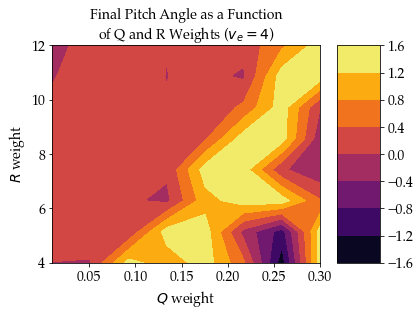

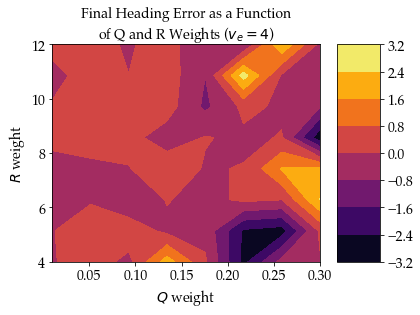

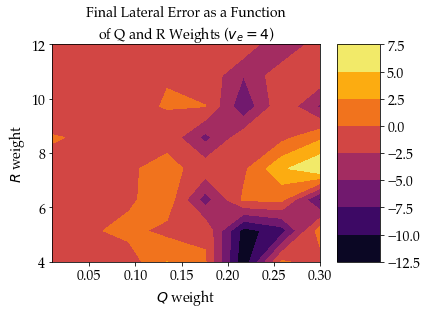

In [22]:
# print Q, R, and data for Q & R that produce an acceptable final theta at the end of simulation
for i in range(Q.shape[0]):
    for j in range(Q.shape[0]):
        
        # set the range of acceptable final theta measurements
        if abs(test_theta[i, j]) < 0.01: # <-- adjustable
            print('Q = ', Q[i,j], '\nR = ', R[i,j])
            print('theta = ', test_theta[i,j], '\nheading error = ', test_e_h[i, j], '\nlateral error = ', test_e_l[i, j], '\n')

fig, ax = plt.subplots()
surf = plt.contourf(Q, R, test_theta, cmap=cm.inferno)
cbar = fig.colorbar(surf, shrink=1, aspect=5)
cbar.ax.tick_params(labelsize=14) 
ax.set_xlabel( '$Q$ weight', fontsize= 14)
ax.set_ylabel( '$R$ weight', fontsize= 14)
ax.tick_params(labelsize=14)
ax.set_title( 'Final Pitch Angle as a Function\nof Q and R Weights ($v_e = 4$)', fontsize=14)
fig.savefig('figa_theta.png', facecolor='white', transparent=False)

fig, ax = plt.subplots()
surf = plt.contourf(Q, R, test_e_h, cmap=cm.inferno)
cbar = fig.colorbar(surf, shrink=1, aspect=5)
cbar.ax.tick_params(labelsize=14) 
ax.set_xlabel( '$Q$ weight', fontsize= 14)
ax.set_ylabel( '$R$ weight', fontsize= 14)
ax.tick_params(labelsize=14)
ax.set_title( 'Final Heading Error as a Function\nof Q and R Weights ($v_e = 4$)', fontsize=14)
fig.savefig('figb_e_h.png', facecolor='white', transparent=False)

fig, ax = plt.subplots()
surf = plt.contourf(Q, R, test_e_l, cmap=cm.inferno)
cbar = fig.colorbar(surf, shrink=1, aspect=5)
cbar.ax.tick_params(labelsize=14) 
ax.set_xlabel( '$Q$ weight', fontsize= 14)
ax.set_ylabel( '$R$ weight', fontsize= 14)
ax.tick_params(labelsize=14)
ax.set_title( 'Final Lateral Error as a Function\nof Q and R Weights ($v_e = 4$)', fontsize=14)
fig.savefig('figc_e_l.png', facecolor='white', transparent=False)

## Show results for a particular choice of equilibrium point, gain matrix, and initial conditions

In [43]:
# define equilibrium point
e_l_e   = 0
e_h_e   = 0
w_e     = 0
theta_e = 0
phi_e   = 0
tau_R_e = 0
tau_L_e = 0
v_e     = 4. # <-- ADJUSTABLE

# define initial conditions
v_i     = 1.    # initial_speed (1.)
e_l_i   = 0.    # initial_lateral_error (0.)
e_h_i   = 0.    # initial_heading_error (0.)
theta_i = 0.    # initial_pitch (0.)
sv_i    = -0.5  # station_velocity(-0.5)

# get A and B matrices
A, B = get_model(
    e_l_e,
    e_h_e,
    v_e,
    w_e,
    theta_e,
    phi_e,
    tau_R_e,
    tau_L_e
)

# define K matrix for linear state feedback
# define weights
Q = np.eye(6) * 0.01 # <-- adjustable
R = np.eye(2) * 4.   # <-- adjustable

# find optimal cost matrix
P = linalg.solve_continuous_are(A, B, Q, R)

# find optimal gain matrix
K = linalg.inv(R) @  B.T @ P

# print K matrix and verify that eigenvalues have all real part
print('K = \n', K)
print('\neigenvalues, s = \n', linalg.eigvals(A - B @ K))

# get simulator data for chosen equilibrium point and initial conditions
data = get_data(
    simulator, 
    e_l_e,
    e_h_e,
    v_e,
    w_e,
    theta_e,
    phi_e,
    tau_R_e,
    tau_L_e,
    K,
    v_i, 
    e_l_i, 
    e_h_i, 
    theta_i, 
    sv_i,
    max_time=20.0
)

K = 
 [[  0.03535534   0.42630818  -0.03535534   0.63812378 -10.53251188
   -0.46215797]
 [ -0.03535534  -0.42630818  -0.03535534  -0.63812378 -10.53251188
   -0.46215797]]

eigenvalues, s = 
 [ -0.66548729+0.j         -0.33737847+0.5766315j  -0.33737847-0.5766315j
 -25.21446606+0.j        -21.48332612+0.j         -0.01394626+0.j       ]


## Get simulation data for various initial conditions and plot the corresponding final measurements (establish limits of performance)

In [44]:
# define equilibrium point
e_l_e   = 0
e_h_e   = 0
w_e     = 0
theta_e = 0
phi_e   = 0
tau_R_e = 0
tau_L_e = 0
v_e     = 4. # <-- ADJUSTABLE

# get A and B matrices
A, B = get_model(
    e_l_e,
    e_h_e,
    v_e,
    w_e,
    theta_e,
    phi_e,
    tau_R_e,
    tau_L_e
)

# define K matrix for linear state feedback
# define weights
Q = np.eye(6) * 0.01 # <-- adjustable
R = np.eye(2) * 4.   # <-- adjustable
# find optimal cost matrix
P = linalg.solve_continuous_are(A, B, Q, R)
# find optimal gain matrix
K = linalg.inv(R) @  B.T @ P

# define initial conditions
v_i     = 1.    # initial_speed (1.)
e_l_i   = 0.    # initial_lateral_error (0.)
e_h_i   = 0.    # initial_heading_error (0.)
sv_i    = -0.5  # station_velocity(-0.5)

# define range of initial conditions to test over
theta_i_range = np.linspace(theta_e - 0.4, theta_e + 0.4, 25)

# initialize empty array to hold final conditions
theta_final = np.empty_like(theta_i_range)

# iterate over all initial conditions
for i in range(theta_i_range.shape[0]):
    data = get_data(
        simulator, 
        e_l_e,
        e_h_e,
        v_e,
        w_e,
        theta_e,
        phi_e,
        tau_R_e,
        tau_L_e,
        K,
        v_i, 
        e_l_i, 
        e_h_i, 
        theta_i_range[i], 
        sv_i,
        max_time=20.0
    )
    
    # store data
    theta_final[i] = data['pitch_angle'][-1]

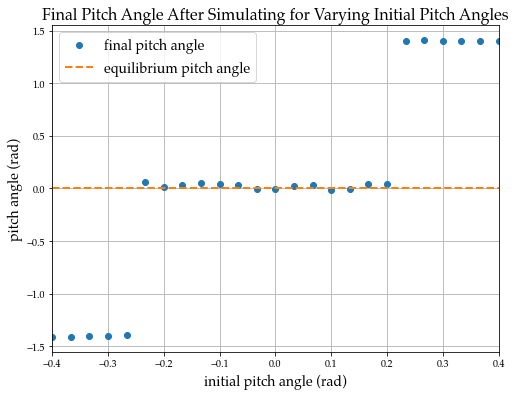

In [45]:
# plot results
fig, (ax) = plt.subplots(1, 1, figsize=(8, 6), sharex=True)

ax.plot(theta_i_range, theta_final, '.', markersize=12, label='final pitch angle')
ax.plot(theta_i_range, theta_e * np.ones_like(theta_i_range), '--', linewidth=2, label='equilibrium pitch angle')
ax.set_xlim(theta_i_range[0], theta_i_range[-1])
# ax.set_ylim(np.pi-1,np.pi+1)
ax.set_xlabel('initial pitch angle (rad)', fontsize=14)
ax.set_ylabel('pitch angle (rad)', fontsize = 14)
ax.set_title('Final Pitch Angle After Simulating for Varying Initial Pitch Angles', fontsize=16)
ax.legend(fontsize=14)
ax.grid()

Get, show, and save a snapshot of the simulation after the last time step.

In [ ]:
# # Get snapshot as height x width x 4 numpy array of RGBA values
# rgba = simulator.snapshot()

# # Display snapshot
# plt.figure(figsize=(8, 8))
# plt.imshow(rgba)

# # Save snapshot
# plt.imsave('my_snapshot.png', rgba)

Plot the results.

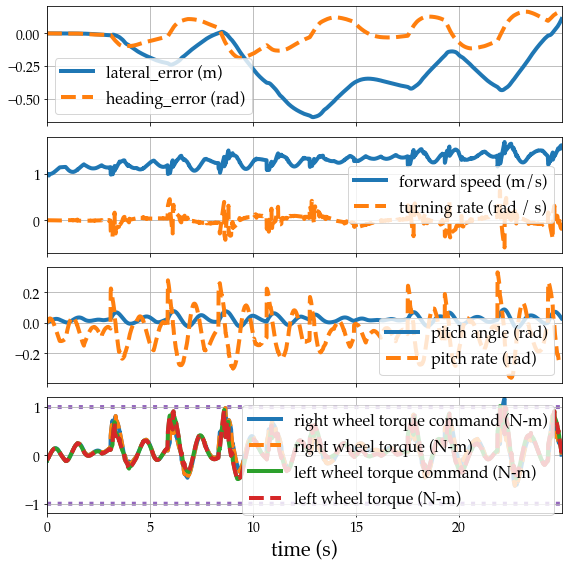

In [24]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=4,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=4,
)
ax_pos.grid()
ax_pos.legend(fontsize=16)
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=4,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=4,
)
ax_vel.grid()
ax_vel.legend(fontsize=16)
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=4,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad)', linewidth=4,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=16)
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

In [25]:
data['forward_speed']

array([1.        , 0.99385722, 0.98876225, ..., 1.61366942, 1.61629838,
       1.54954315])

Save the figure (without transparent background).

In [ ]:
# fig.savefig('my_figure.png', facecolor='white', transparent=False)